In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

# Load the train and test sets

In [2]:
train = pd.read_csv( '../input/liverpool-ion-switching/train.csv' , dtype={'time':'str','signal':'float','open_channels':'int'} )
test  = pd.read_csv( '../input/liverpool-ion-switching/test.csv'  , dtype={'time':'str','signal':'float'} )

# Split trainset in groups of 100k and 500k consecutive rows
train['group']  = np.arange(train.shape[0])//100_000
train['group2'] = np.arange(train.shape[0])//500_000

# Split testset in groups of 100k consecutive rows
test['group']   = np.arange(test.shape[0])//100_000

# Fix train and test signal levels.
## Train 500k groups 4 and 9 and test 100k groups 5 and 7 needs to be shifted by +2*exp(1)
## Other groups are shifted by +exp(1)
## All groups must be rescaled by 1.25 to match open_channels scale

In [3]:
train.loc[ (train.group2==4)|(train.group2==9) ,'signal'] += np.exp(1)
test.loc[  ( test.group ==5)|( test.group ==7) ,'signal'] += np.exp(1)

train['signal'] += np.exp(1)
train['signal'] /= 1.25

test['signal'] += np.exp(1)
test['signal'] /= 1.25

## Analyzing the signal and target statistics we classified each train and test groups as xA and xB, where x is the maximum number of simultaneous open_channels per group

In [4]:
MAP = {0:'1A', 1:'1A', 2:'1B', 3:'3B', 4:'10B', 5:'5B', 6:'1B', 7:'3B', 8:'5B', 9:'10B'}
train['type'] = train['group2'].map( MAP )

MAP = {0:'3A', 1:'3B', 2:'5B', 3:'3A', 4:'1B', 5:'10B', 6:'5B', 7:'10B', 8:'3A', 9:'3B',10:'3A', 11:'3A', 12:'4A', 13:'3A', 14:'3A', 15:'3A', 16:'3A', 17:'3A', 18:'3A', 19:'3A'}
test['type'] = test['group'].map( MAP )

# Observe the drifts in trainset

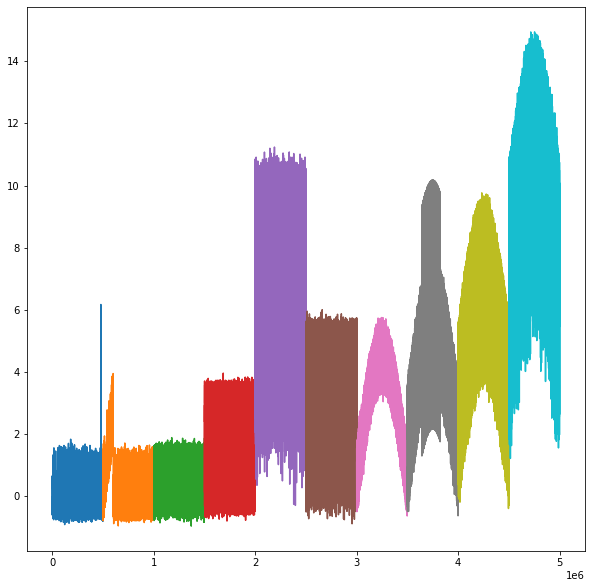

In [5]:
for i in range(10):
    train.loc[train.group2==i].signal.plot()

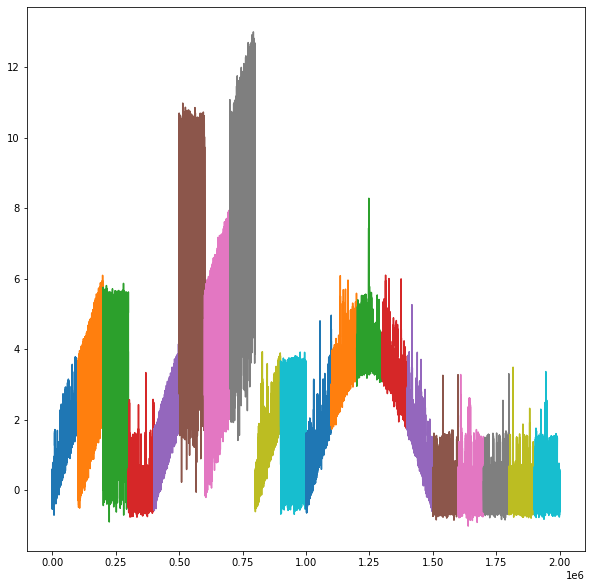

In [6]:
for i in range(20):
    test.loc[test.group==i].signal.plot()

# After deep analisys we found that all the drifts come from the same equation:
## 4 * sin(  2 * pi * range(500000) / 1000000  )

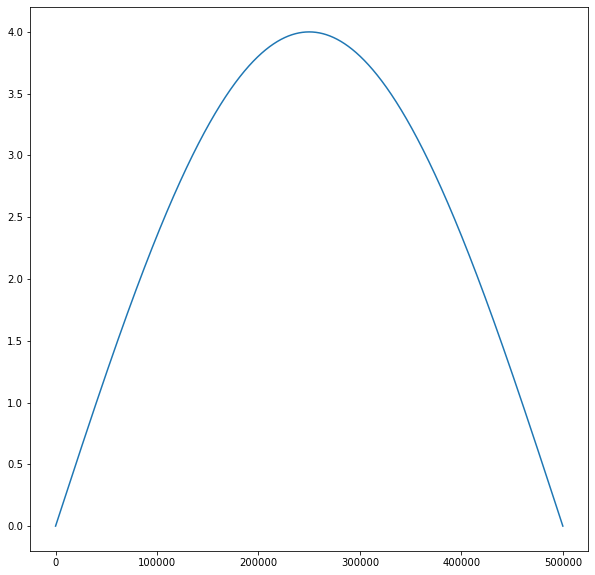

In [7]:
SINE_DRIFT = 4*np.sin(  2*np.pi*np.arange(500000)/1000000 )
plt.plot( SINE_DRIFT )

# Remove the drift from train and test

In [8]:
train.loc[ train.group2==6, 'signal' ] -= SINE_DRIFT
train.loc[ train.group2==7, 'signal' ] -= SINE_DRIFT
train.loc[ train.group2==8, 'signal' ] -= SINE_DRIFT
train.loc[ train.group2==9, 'signal' ] -= SINE_DRIFT

train.signal.iloc[ 500000:600000 ]-= SINE_DRIFT[:100000]

test.signal.iloc[ :100000 ]       -= SINE_DRIFT[:100000]
test.signal.iloc[ 100000:200000 ] -= SINE_DRIFT[:100000]
test.signal.iloc[ 400000:500000 ] -= SINE_DRIFT[:100000]
test.signal.iloc[ 600000:700000 ] -= SINE_DRIFT[:100000]
test.signal.iloc[ 700000:800000 ] -= SINE_DRIFT[:100000]
test.signal.iloc[ 800000:900000 ] -= SINE_DRIFT[:100000]

test.loc[ (test.group>=10)&(test.group<=14), 'signal' ] -= SINE_DRIFT

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [9]:
train.groupby(['group2','type'])['signal'].agg(['mean','std'])

,,mean,std
group2,type,,
0,1A,0.029500,0.263704
1,1A,0.028141,0.276412
2,1B,0.724126,0.472295
3,3B,2.100238,0.802234
4,10B,7.035497,1.454612
5,5B,3.519300,1.022926
6,1B,0.731483,0.468954
7,3B,2.088336,0.936376
8,5B,3.501796,1.027344


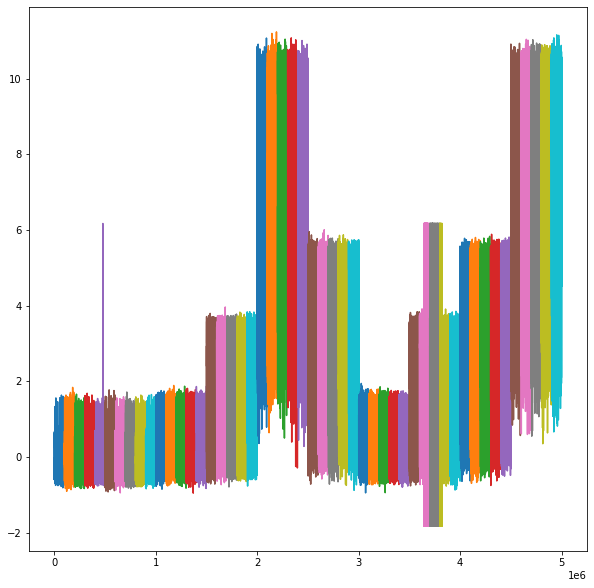

In [10]:
for i in range(50):
    train.loc[train.group==i].signal.plot()

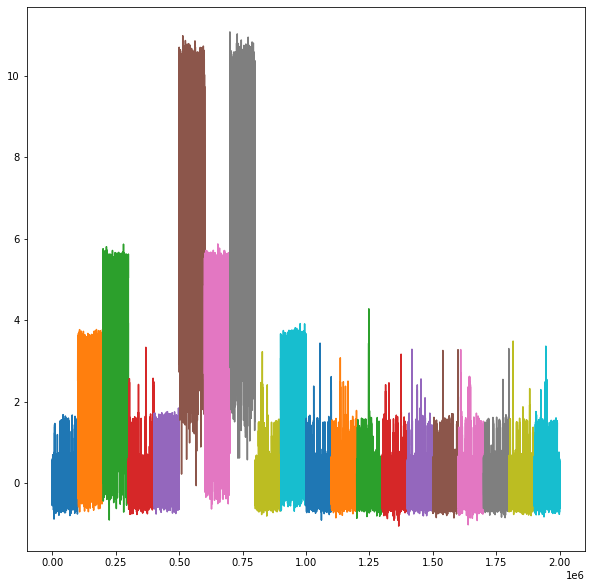

In [11]:
for i in range(20):
    test.loc[test.group==i].signal.plot()

# Remove outlier on train 100k batch group 4
## this outlier pattern happens only on trainset so its safe to remove it.

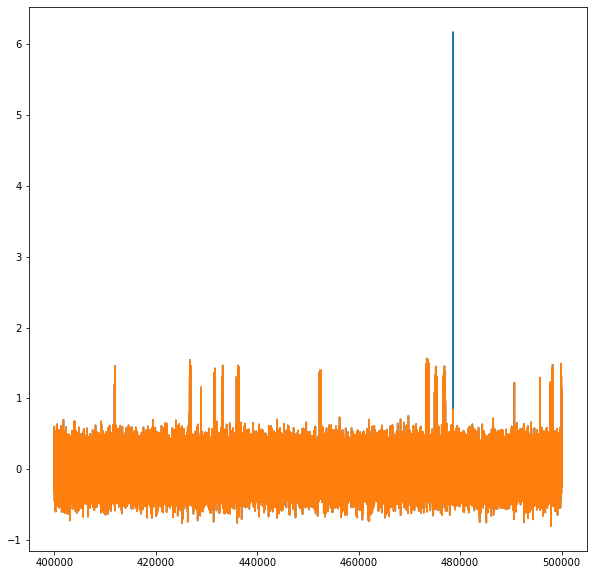

In [12]:
train.loc[train.group==4].signal.plot()

train['noise'] = train['signal'] - train['open_channels']
train.loc[ (train.group==4)&(train.noise>1.0), 'signal' ] = np.random.normal( 0,0.2,1 ) #Just add gaussian noise with std 0.20

train.loc[train.group==4].signal.plot()

# Remove/Decrease 50Hz power line interference

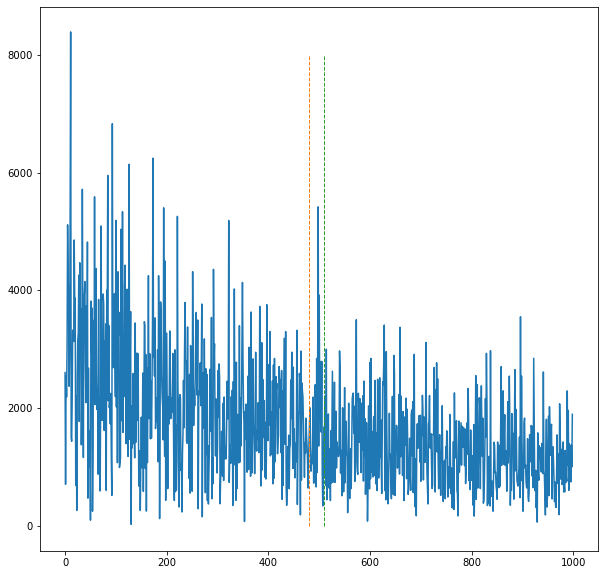

In [13]:
# Power line 50Hz interference is that small peak at axis 500 of the plot below
# We used Fourier Transform to remove it precisely
f = np.fft.fft( train.loc[train.group==45].signal )
plt.plot( np.abs(f)[1:1000] )
plt.plot([480, 480], [0, 8000], '--', lw=1)
plt.plot([510, 510], [0, 8000], '--', lw=1)

In [14]:
from scipy import fftpack

# Removing 100% of power line interference can remove also usefull information that lies in the 50Hz spectrum.
# Thats why we removed only 45% of powerline interference in order to keep some useful signal present in the 50Hz.
# Remove 50Hz in batches of 100k rows.

for g in range( train.group.max() ):
    f = np.fft.fft( train.loc[train.group==g].signal )
    freq = np.abs( fftpack.fftfreq( len(f) , d=0.0001) )
    f[ (freq >= 49.8)& (freq <= 50.2) ] = 0.55*f[ (freq >= 49.8)& (freq <= 50.2) ]
    train.loc[train.group==g,'signal'] = np.fft.ifft( f ).real
    
for g in range( test.group.max() ):
    f = np.fft.fft( test.loc[test.group==g].signal )
    freq = np.abs( fftpack.fftfreq( len(f) , d=0.0001) )
    f[ (freq >= 49.8)& (freq <= 50.2) ] = 0.55*f[ (freq >= 49.8)& (freq <= 50.2) ]
    test.loc[test.group==g,'signal'] = np.fft.ifft( f ).real
    

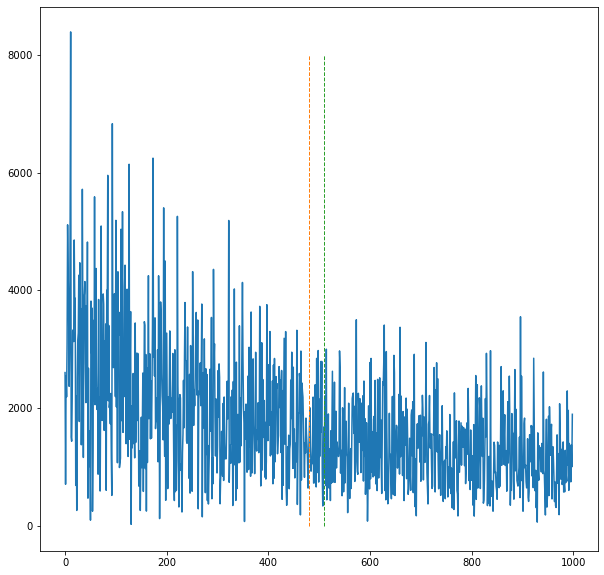

In [15]:
#Note that the 50Hz frequency interference was decreased but not removed 100%.
f = np.fft.fft( train.loc[train.group==45].signal )
plt.plot( np.abs(f)[1:1000] )
plt.plot([480, 480], [0, 8000], '--', lw=1)
plt.plot([510, 510], [0, 8000], '--', lw=1)

# Now that signal and open_channels are in the same scale, to calculate the noise added to each row it is just a mater of subtract each other.

In [16]:
# Calculate real noise in train set.
# This is only possible because signal and open_channels are in the same scale
train['noise']       = train['signal'] - train['open_channels']

# Subtracting signal from round(signal) is a pseudo way to calculate noise that can be applied both to train and test sets.
train['noise_round'] = train['signal'] - train['signal'].round()
test ['noise_round'] = test ['signal'] - test ['signal'].round()

In [17]:
#This is the bias offset and Standard deviation of the noise added to each group type.
train.groupby(['group2','type'])['noise'].agg( ['mean','std'] )

,,mean,std
group2,type,,
0,1A,-0.002262,0.196642
1,1A,-0.010535,0.198427
2,1B,-0.023866,0.197516
3,3B,-0.047608,0.215099
4,10B,-0.111689,0.328370
5,5B,-0.057384,0.231869
6,1B,-0.022127,0.197614
7,3B,-0.046850,0.529125
8,5B,-0.068508,0.230457


# Note that the std of the gaussian noise above is different for each type:
## Type 1A sdt ~ 0.197
## Type 1B sdt ~ 0.197
## Type 3B sdt ~ 0.215
## Type 5B sdt ~ 0.231
## Type 10B sdt ~ 0.327

# Adding 2x 5B std noise gives:

In [18]:
x = np.random.normal( 0, 0.231, 1000000) + np.random.normal( 0, 0.231, 1000000)
np.std(x)

0.32616251485274766

# The result above makes us think that the 10 channels groups are the sum of two 5 channels groups

# Since we can't have the real noise in test set, we can approximate the noise in test using signal-signal.round() as a proxy for the noise.

In [19]:
train.groupby(['group2','type'])['noise_round'].agg( ['mean','std'] )

,,mean,std
group2,type,,
0,1A,-0.001712,0.193047
1,1A,-0.008665,0.194528
2,1B,-0.019756,0.194028
3,3B,-0.035074,0.209271
4,10B,-0.023801,0.271217
5,5B,-0.037514,0.222168
6,1B,-0.018733,0.194202
7,3B,-0.026224,0.223371
8,5B,-0.044964,0.222016


In [20]:
test.groupby(['group','type'])['noise_round'].agg( ['mean','std'] )

,,mean,std
group,type,,
0,3A,0.016195,0.188998
1,3B,-0.032072,0.215247
2,5B,-0.054148,0.225150
3,3A,0.014675,0.188260
4,1B,-0.012774,0.194180
5,10B,-0.032938,0.273609
6,5B,-0.043632,0.221615
7,10B,-0.029761,0.272744
8,3A,0.006313,0.189294


# # Removing outliers from 100k groups batches 36, 37 and 38 of trainset

## We can cleanly see that there is an interference in the 3B groups in trainset and the corresponding 3B groups in test doesn't have such interference.

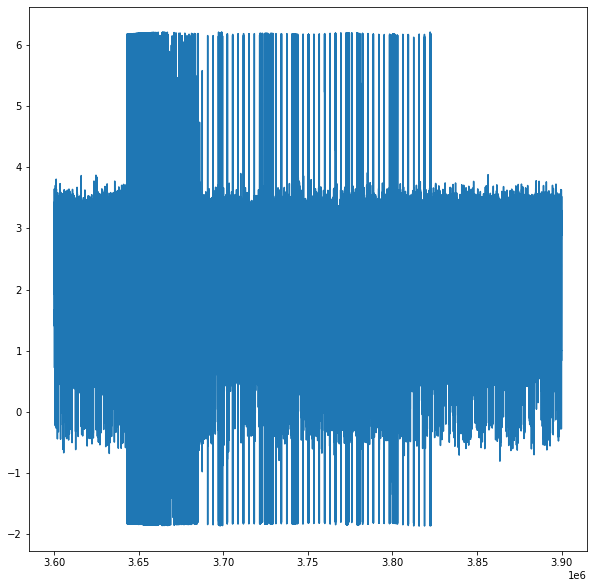

In [21]:
train.loc[ train.group.isin([36,37,38]) ,'signal'].plot()

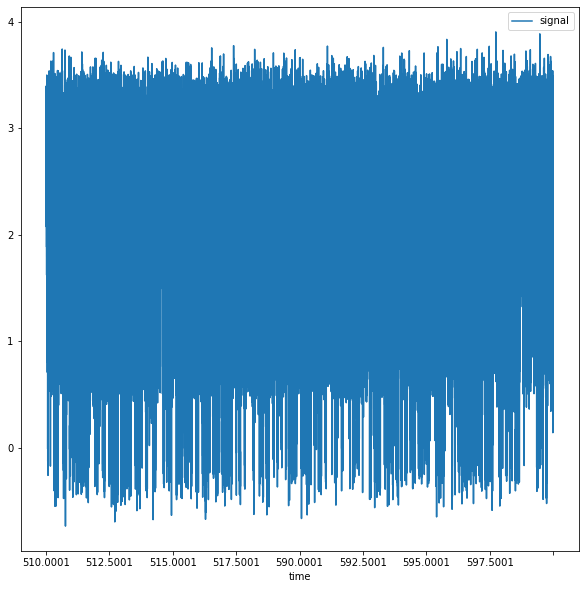

In [22]:
test.loc[ test.type=='3B'].plot( x='time' ,y='signal' )

In [23]:
print( train.loc[ train.group==35 ].groupby('open_channels')['noise'].agg(['mean','std']) )
print( train.loc[ train.group==39 ].groupby('open_channels')['noise'].agg(['mean','std']) )

                   mean       std
open_channels                    
0             -0.013897  0.234267
1             -0.029991  0.235692
2             -0.046818  0.236887
3             -0.060700  0.234445
                   mean       std
open_channels                    
0             -0.008225  0.220314
1             -0.030110  0.223126
2             -0.043494  0.221525
3             -0.055838  0.221871


## to remove the outliers, lets just add a gaussian noise to open_channels with a specific std level for the specific batches.

In [24]:
tmp = train.loc[ train.group==36 ].copy()
tmp.loc[ tmp.open_channels==0 ,'signal'] = 0 + np.random.normal(  -0.0130 , 0.2342, np.sum(tmp.open_channels==0) )
tmp.loc[ tmp.open_channels==1 ,'signal'] = 1 + np.random.normal(  -0.0299 , 0.2356, np.sum(tmp.open_channels==1) )
tmp.loc[ tmp.open_channels==2 ,'signal'] = 2 + np.random.normal(  -0.0460 , 0.2368, np.sum(tmp.open_channels==2) )
tmp.loc[ tmp.open_channels==3 ,'signal'] = 3 + np.random.normal(  -0.0600 , 0.2344, np.sum(tmp.open_channels==3) )
train.loc[ train.group==36 ] = tmp.copy()

tmp = train.loc[ train.group==37 ].copy()
tmp.loc[ tmp.open_channels==0 ,'signal'] = 0 + np.random.normal(  -0.0110 , 0.2307, np.sum(tmp.open_channels==0) )
tmp.loc[ tmp.open_channels==1 ,'signal'] = 1 + np.random.normal(  -0.0299 , 0.2309, np.sum(tmp.open_channels==1) )
tmp.loc[ tmp.open_channels==2 ,'signal'] = 2 + np.random.normal(  -0.0450 , 0.2368, np.sum(tmp.open_channels==2) )
tmp.loc[ tmp.open_channels==3 ,'signal'] = 3 + np.random.normal(  -0.0580 , 0.2295, np.sum(tmp.open_channels==3) )
train.loc[ train.group==37 ] = tmp.copy()

tmp = train.loc[ train.group==38 ].copy()
tmp.loc[ tmp.open_channels==0 ,'signal'] = 0 + np.random.normal(  -0.0100 , 0.2257, np.sum(tmp.open_channels==0) )
tmp.loc[ tmp.open_channels==1 ,'signal'] = 1 + np.random.normal(  -0.0299 , 0.2275, np.sum(tmp.open_channels==1) )
tmp.loc[ tmp.open_channels==2 ,'signal'] = 2 + np.random.normal(  -0.0440 , 0.2278, np.sum(tmp.open_channels==2) )
tmp.loc[ tmp.open_channels==3 ,'signal'] = 3 + np.random.normal(  -0.0560 , 0.2245, np.sum(tmp.open_channels==3) )
train.loc[ train.group==38 ] = tmp.copy()

train['noise'] = train['signal'] - train['open_channels']

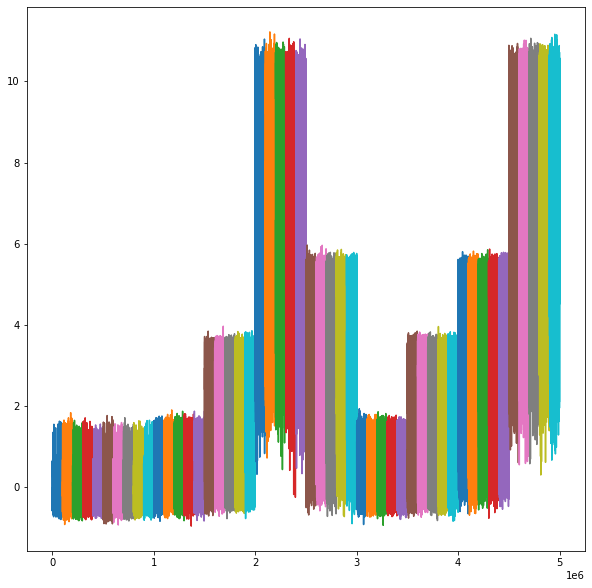

In [25]:
# Now all train groups looks fine
for i in range(50):
    train.loc[train.group==i].signal.plot()

In [26]:
# Now outlier group 7(3B) have similar statistics as group 3(3B)
train.groupby(['group2','type'])['signal'].agg(['mean','std'])

,,mean,std
group2,type,,
0,1A,0.029470,0.262160
1,1A,0.028141,0.275307
2,1B,0.724126,0.471517
3,3B,2.100238,0.801170
4,10B,7.035497,1.452484
5,5B,3.519300,1.021385
6,1B,0.731483,0.468361
7,3B,2.088956,0.810850
8,5B,3.501796,1.026044


# There still some bias to be removed per group, both in train and in test

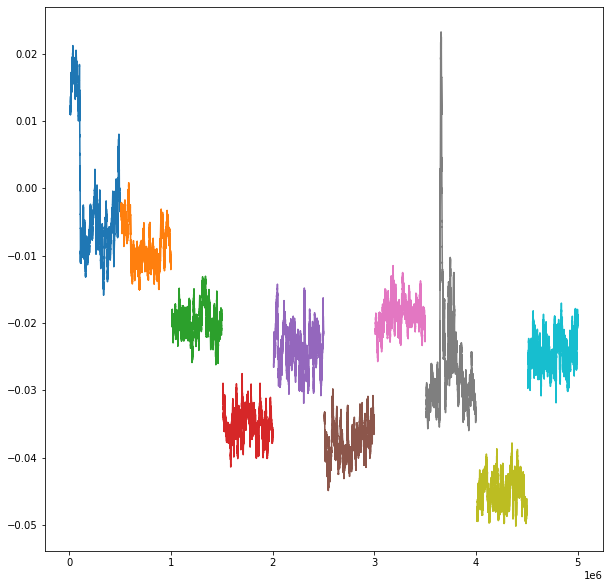

In [27]:
for i in range(50):
    train.loc[train.group2==i].noise_round.rolling(10000).mean().plot()

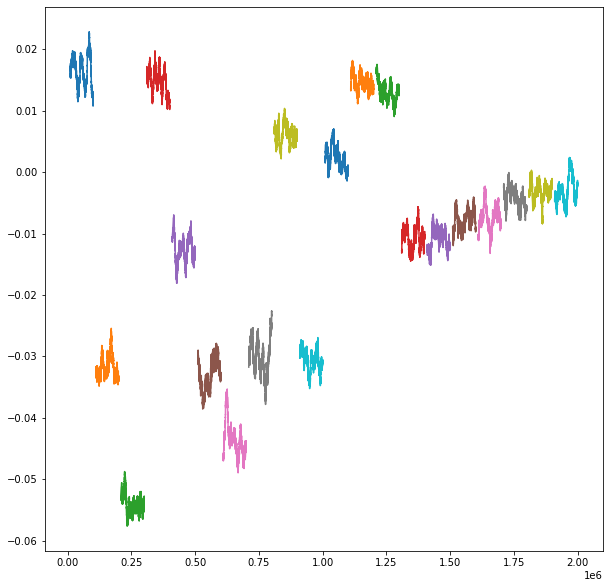

In [28]:
for i in range(20):
    test.loc[test.group==i].noise_round.rolling(10000).mean().plot()

# Remove the bias

In [29]:
#Remove the bias offset using an iterative loop for both train and test sets

train['noise_round'] = train['signal'] - train['signal'].round()
test ['noise_round'] = test ['signal'] - test ['signal'].round()
for i in range( 7 ):
    train['bias'] = train.groupby('group')['noise_round'].transform('mean')
    test ['bias'] = test.groupby( 'group')['noise_round'].transform('mean')
    
    train['signal'] = train['signal'] - train['bias']
    test ['signal'] = test ['signal'] - test ['bias']
    train['noise_round'] = train['signal'] - train['signal'].round()
    test ['noise_round'] = test ['signal'] - test ['signal'].round()
    
    print( i, 'acc:',np.mean( train.open_channels == train.signal.round() ) , 'f1:',f1_score( train.open_channels , np.clip(train.signal.round(),0,10), average='macro' ) )

train['noise'] = train['signal'] - train['open_channels']
train['noise_round'] = train['signal'] - train['signal'].round()
test ['noise_round'] = test ['signal'] - test ['signal'].round()

0 acc: 0.9557062 f1: 0.9213712178547261
1 acc: 0.9570054 f1: 0.9235790091556773
2 acc: 0.957712 f1: 0.924779757880053
3 acc: 0.9581332 f1: 0.9254173067188076
4 acc: 0.958376 f1: 0.9257278710520267
5 acc: 0.9585382 f1: 0.9259281785018462
6 acc: 0.9586118 f1: 0.9259411514318903


In [30]:
#Check bias offsets now. Must be close to zero.
train.groupby(['group','type'])['noise'].agg(['mean','std'])

,,mean,std
group,type,,
0,1A,-0.00004,0.191095
1,1A,0.00020,0.198332
2,1A,-0.00070,0.198341
3,1A,-0.00041,0.198023
4,1A,0.00037,0.195856
5,1A,-0.00006,0.212421
6,1A,-0.00031,0.194574
7,1A,-0.00017,0.194733
8,1A,-0.00068,0.194977


In [31]:
train.groupby(['group','type'])['noise_round'].agg(['mean','std'])

,,mean,std
group,type,,
0,1A,-3.298195e-18,0.188202
1,1A,-2.960410e-18,0.194630
2,1A,2.666478e-18,0.194215
3,1A,2.259859e-18,0.194268
4,1A,2.109146e-18,0.192577
5,1A,3.861494e-18,0.206112
6,1A,-2.478295e-18,0.191375
7,1A,1.812717e-18,0.191449
8,1A,-2.023937e-18,0.191520


In [32]:
test.groupby(['group','type'])['noise_round'].agg(['mean','std'])

,,mean,std
group,type,,
0,3A,-2.929601e-18,0.188878
1,3B,3.783640e-17,0.214222
2,5B,-2.000000e-05,0.221071
3,3A,5.095924e-19,0.188168
4,1B,1.827094e-17,0.194082
5,10B,-5.620000e-03,0.265797
6,5B,-3.000000e-05,0.219211
7,10B,-4.490000e-03,0.266267
8,3A,9.356405e-19,0.189278


# Now the bias offset are close to zero. But still a small bias offset in groups 10B.


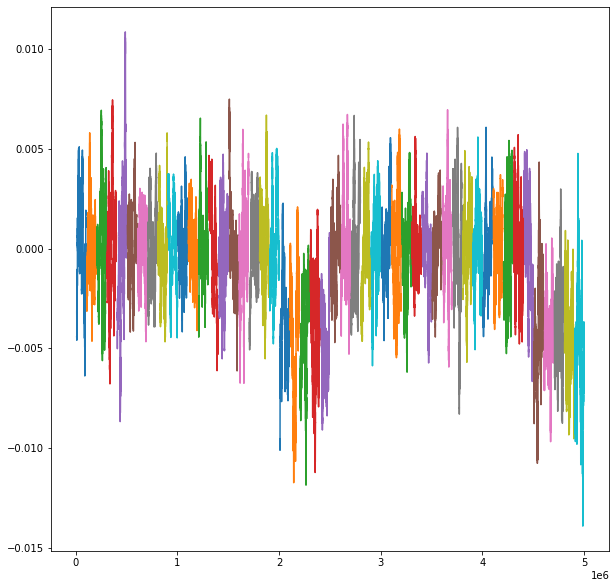

In [33]:
for i in range(50):
    train.loc[train.group==i].noise_round.rolling(10000).mean().plot()

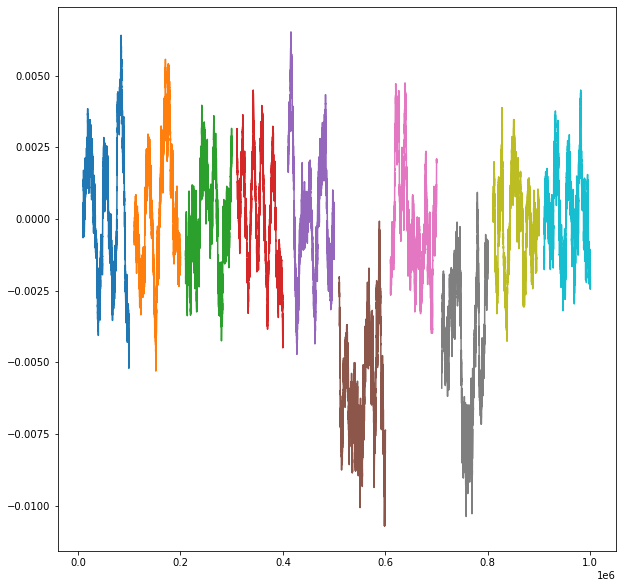

In [34]:
# The bias offset in groups 10B in train is at the same level as in test, so don't worry about it. 
for i in range(10):
    test.loc[test.group==i].noise_round.rolling(10000).mean().plot()

# Accuracy and F1 using only round(signal) as a predictor.

In [35]:
print( 'ACC:', np.mean( train.open_channels == train.signal.round() )  )
print( 'F1:', f1_score( train.open_channels , np.clip(train.signal.round(),0,10), average='macro' ) )

ACC: 0.9586118
F1: 0.9259411514318903


In [36]:
#Calc ACC per group
train['hit'] = train.open_channels == train.signal.round()
train.groupby(['group','type'])['hit'].mean()

group  type
0      1A      0.99100
1      1A      0.98852
2      1A      0.98770
3      1A      0.98859
4      1A      0.98911
5      1A      0.98106
6      1A      0.99011
7      1A      0.98975
8      1A      0.98966
9      1A      0.99021
10     1B      0.98816
11     1B      0.98898
12     1B      0.98820
13     1B      0.98857
14     1B      0.98867
15     3B      0.98021
16     3B      0.98078
17     3B      0.97996
18     3B      0.98018
19     3B      0.97956
20     10B     0.87071
21     10B     0.87052
22     10B     0.87160
23     10B     0.87354
24     10B     0.87033
25     5B      0.96809
26     5B      0.96879
27     5B      0.96982
28     5B      0.96841
29     5B      0.96937
30     1B      0.98864
31     1B      0.98942
32     1B      0.98861
33     1B      0.98818
34     1B      0.98929
35     3B      0.96539
36     3B      0.96545
37     3B      0.96759
38     3B      0.97284
39     3B      0.97547
40     5B      0.97130
41     5B      0.96899
42     5B      0.96984

In [37]:
train[['time','signal','type','open_channels']].to_csv('train_clean_giba.csv', index=False )
test [['time','signal','type']].to_csv('test_clean_giba.csv', index=False )